# Cloning the github repo

In [81]:
!git clone -b haider-transformer_model https://github.com/hyder1414/retail-transformer-forecasting.git

fatal: destination path 'retail-transformer-forecasting' already exists and is not an empty directory.


### importing libraries and dataset

In [82]:
import sys
from pathlib import Path
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4)


In [83]:
PARQUET_PATH = "retail-transformer-forecasting/data/interim/hahrt_with_residuals_rc_gbdt.parquet"
df = pd.read_parquet(PARQUET_PATH)
df["Date"] = pd.to_datetime(df["Date"])
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Data shape: (421570, 34)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'week_of_year', 'month', 'year', 'year_index', 'Temp_Anomaly', 'StoreTypeIdx', 'SizeNorm', 'lag_1', 'lag_2', 'lag_7', 'lag_52', 'roll_mean_4', 'roll_mean_8', 'roll_mean_13', 'StoreIdx', 'DeptIdx', 'Baseline_Pred', 'Residual']


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,lag_2,lag_7,lag_52,roll_mean_4,roll_mean_8,roll_mean_13,StoreIdx,DeptIdx,Baseline_Pred,Residual
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4340.781870,20583.718130
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,14448.115070,31591.373211
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,...,24924.50,NaN,NaN,NaN,NaN,NaN,1,0,29216.680944,12378.869838
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,...,46039.49,NaN,NaN,NaN,NaN,NaN,1,0,23470.877612,-4067.338549
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,...,41595.55,NaN,NaN,32990.77,NaN,NaN,1,0,22635.259182,-807.358792


### Feature check

In [84]:
#Checking dataset
if "week_of_year" not in df.columns:
    df["week_of_year"] = df["Date"].dt.isocalendar().week.astype("int64")
if "year" not in df.columns:
    df["year"] = df["Date"].dt.year.astype("int64")
if "year_index" not in df.columns:
    df["year_index"] = df["year"] - df["year"].min()
if "StoreTypeIdx" not in df.columns:
    df["StoreTypeIdx"] = 0
if "SizeNorm" not in df.columns:
    df["SizeNorm"] = 0.0

In [85]:
# cont_cols

expected_cont_cols = [
    "Residual",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Temp_Anomaly",
    "MarkDown1",
    "MarkDown2",
    "MarkDown3",
    "MarkDown4",
    "MarkDown5",
    "lag_1",
    "lag_2",
    "lag_7",
    "lag_52",
    "roll_mean_4",
    "roll_mean_8",
    "roll_mean_13",
]

cont_cols = [c for c in expected_cont_cols if c in df.columns]
print("Using continuous features:", cont_cols)
df[cont_cols] = df[cont_cols].fillna(0.0)
# Sequence length
INPUT_WINDOW = 12


Using continuous features: ['Residual', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Temp_Anomaly', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'lag_1', 'lag_2', 'lag_7', 'lag_52', 'roll_mean_4', 'roll_mean_8', 'roll_mean_13']


# Importing the models (Best and baseline transformer)

In [86]:

sys.path.append("/content/retail-transformer-forecasting/src/models")
from hahrt_model import HAHRTModel, HAHRTConfig

# Build configuration from data
cfg = HAHRTConfig(
    input_dim=len(cont_cols),
    num_stores=int(df["StoreIdx"].max()) + 1,
    num_depts=int(df["DeptIdx"].max()) + 1,
    num_store_types=int(df["StoreTypeIdx"].max()) + 1,
    max_week_of_year=int(df["week_of_year"].max()),
    max_year_index=int(df["year_index"].max()),

)

print("Config:", cfg.__dict__)

#Best Model
model = HAHRTModel(cfg)
MODEL_PATH =  "retail-transformer-forecasting/data/interim/hahrt_best_model.pt"
state = torch.load(MODEL_PATH, map_location="cpu")
model.load_state_dict(state)
model.eval()

#Transformer model
model_rc = HAHRTModel(cfg)
state_rc = torch.load("retail-transformer-forecasting/data/interim/hahrt_best_model_rc_gbdt.pt", map_location="cpu")
model_rc.load_state_dict(state_rc)
model_rc.eval()



Config: {'input_dim': 18, 'num_stores': 46, 'num_depts': 81, 'num_store_types': 3, 'max_week_of_year': 52, 'max_year_index': 2, 'd_model': 128, 'n_heads': 4, 'num_layers': 3, 'd_ff': 256, 'dropout': 0.1, 'holiday_bias_strength': 1.5}


HAHRTModel(
  (input_proj): Linear(in_features=18, out_features=128, bias=True)
  (week_embed): Embedding(53, 128)
  (year_embed): Embedding(3, 128)
  (holiday_embed): Embedding(2, 128)
  (store_embed): Embedding(46, 32)
  (dept_embed): Embedding(81, 32)
  (store_type_embed): Embedding(3, 16)
  (size_mlp): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
  (static_to_film): Sequential(
    (0): Linear(in_features=96, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (layers): ModuleList(
    (0-2): 3 x HolidayAwareTransformerEncoderLayer(
      (self_attn): HolidayAwareSelfAttention(
        (q_proj): Linear(in_features=128, out_features=128, bias=True)
        (k_proj): Linear(in_features=128, out_features=128, bias=True)
        (v_proj): Linear(in_features=128, out_features=128, bias=True)
        (out_proj): Linear(in_f

In [87]:
def build_sample(store: int, dept: int, window: int = INPUT_WINDOW):
    """
    for a given (Store, Dept).
    Uses the last `window` timesteps as input sequence,
    and the last row as the prediction target.
    """
    g = df[(df["Store"] == store) & (df["Dept"] == dept)].sort_values("Date")
    g = g.dropna(subset=["Residual", "Baseline_Pred"])
    if len(g) <= window:
        raise ValueError(f"Not enough data for Store {store}, Dept {dept}")
    seq = g.iloc[-(window + 1):-1]
    target = g.iloc[-1]

    # [1, L, D] continuous features
    x_cont = torch.tensor(
        seq[cont_cols].values.astype("float32"),
        dtype=torch.float32,).unsqueeze(0)
    # [1, L] time features
    week = torch.tensor(
        seq["week_of_year"].values.astype("int64"),
        dtype=torch.long,
    ).unsqueeze(0)
    year_idx = torch.tensor(
        seq["year_index"].values.astype("int64"),
        dtype=torch.long,
    ).unsqueeze(0)
    is_hol = torch.tensor(
        seq["IsHoliday"].values.astype("int64"),
        dtype=torch.long,
    ).unsqueeze(0)
    store_idx = torch.tensor([int(target["StoreIdx"])], dtype=torch.long)
    dept_idx = torch.tensor([int(target["DeptIdx"])], dtype=torch.long)
    store_type_idx = torch.tensor([int(target["StoreTypeIdx"])], dtype=torch.long)
    size_norm = torch.tensor([float(target["SizeNorm"])], dtype=torch.float32)

    batch = {
        "x_cont": x_cont,
        "week_of_year": week,
        "year_idx": year_idx,
        "is_holiday": is_hol,
        "store_idx": store_idx,
        "dept_idx": dept_idx,
        "store_type_idx": store_type_idx,
        "size_norm": size_norm,
    }

    baseline = float(target["Baseline_Pred"])
    actual = float(target["Weekly_Sales"])
    return batch, baseline, actual, seq, target


## Best model demonstration

In [88]:
def run_demo(store: int, dept: int):
    batch, baseline, actual, seq, target = build_sample(store, dept)

    with torch.no_grad():
        resid_pred = model(batch).item()

    final_pred = baseline + resid_pred

    print(f"Store {store}, Dept {dept}")
    print("-" * 40)
    print(f"Baseline prediction:      {baseline:,.2f}")
    print(f"Transformer residual:     {resid_pred:,.2f}")
    print(f"Final prediction:      {final_pred:,.2f}")
    print(f" Actual Weekly_Sales:   {actual:,.2f}")

    return seq, target, final_pred

seq, target, final_pred = run_demo(store=5, dept=10)


Store 5, Dept 10
----------------------------------------
Baseline prediction:      11,299.41
Transformer residual:     -16.54
Final prediction:      11,282.87
 Actual Weekly_Sales:   8,693.19


Store 5, Dept 10
----------------------------------------
Baseline prediction:      11,299.41
Transformer residual:     -16.54
Final prediction:      11,282.87
 Actual Weekly_Sales:   8,693.19


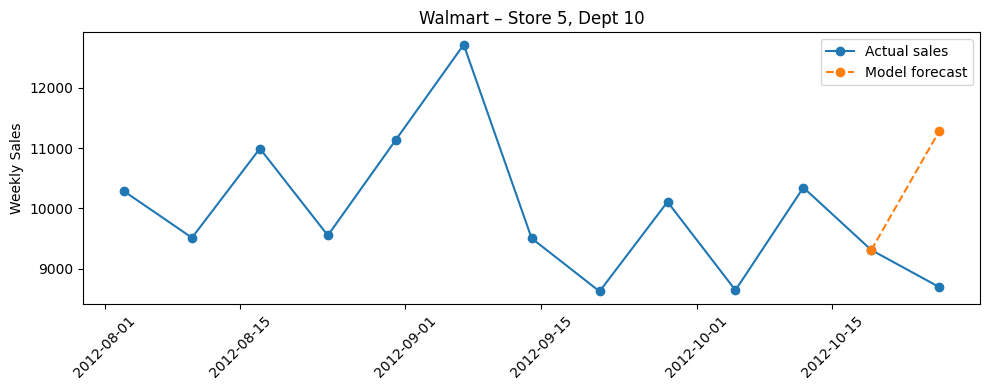

In [89]:
def plot_demo(store: int, dept: int):
    seq, target, final_pred = run_demo(store, dept)
    history = seq.copy()
    dates = list(history["Date"]) + [target["Date"]]
    actuals = list(history["Weekly_Sales"]) + [target["Weekly_Sales"]]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, actuals, marker="o", label="Actual sales")
    plt.plot(
        [dates[-2], dates[-1]],
        [actuals[-2], final_pred],
        "--o",
        label="Model forecast",
    )
    plt.xticks(rotation=45)
    plt.ylabel("Weekly Sales")
    plt.title(f"Walmart – Store {store}, Dept {dept}")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_demo(5, 10)


In [90]:
import ipywidgets as widgets
from ipywidgets import interact

store_options = sorted(df["Store"].unique().tolist())
dept_options = sorted(df["Dept"].unique().tolist())
@interact(store=store_options, dept=dept_options)
def interactive_demo(store=1, dept=1):
    try:
        plot_demo(store, dept)
    except ValueError as e:
        print(e)


interactive(children=(Dropdown(description='store', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

# Comparing with the baseline transformer

In [91]:
def model_comps(store: int, dept: int):
    batch, baseline, actual, seq, target = build_sample(store, dept)

    with torch.no_grad():
        resid_best = model(batch).item()
        resid_rc   = model_rc(batch).item()

    pred_best = baseline + resid_best
    pred_rc   = baseline + resid_rc

    print(f"Store {store}, Dept {dept}")
    print("-" * 40)
    print(f"Baseline prediction:     {baseline:,.2f}")
    print(f"Best model residual:     {resid_best:,.2f}")
    print(f"RC model residual:       {resid_rc:,.2f}")
    print(f"Best model final pred:   {pred_best:,.2f}")
    print(f"RC model final pred:     {pred_rc:,.2f}")
    print(f" Actual Weekly_Sales:  {actual:,.2f}")

    return {
        "baseline": baseline,
        "actual": actual,
        "pred_best": pred_best,
        "pred_rc": pred_rc,
    }
model_comps(1, 1)


Store 1, Dept 1
----------------------------------------
Baseline prediction:     20,319.89
Best model residual:     4.24
RC model residual:       3,848.65
Best model final pred:   20,324.13
RC model final pred:     24,168.54
 Actual Weekly_Sales:  27,390.81


{'baseline': 20319.887212829362,
 'actual': 27390.81,
 'pred_best': 20324.125628070604,
 'pred_rc': 24168.541265563737}

In [96]:


def compare_models_many(num_samples: int = 50):
    rows = df.dropna(subset=["Residual", "Baseline_Pred"])
    stores = rows["Store"].unique()
    depts = rows["Dept"].unique()

    diffs_best = []
    diffs_rc = []

    for _ in range(num_samples):
        s = int(random.choice(stores))
        d = int(random.choice(depts))
        try:
            res = model_comps(s, d)
        except ValueError:
            continue

        diffs_best.append(abs(res["pred_best"] - res["actual"]))
        diffs_rc.append(abs(res["pred_rc"] - res["actual"]))

    print("\n Average Absolute Error over samples")
    print("RC model MAE:", np.mean(diffs_best))
    print("BEST model MAE:  ", np.mean(diffs_rc))

compare_models_many(30)



Store 4, Dept 29
----------------------------------------
Baseline prediction:     11,299.41
Best model residual:     205.90
RC model residual:       292.78
Best model final pred:   11,505.32
RC model final pred:     11,592.19
 Actual Weekly_Sales:  10,045.10
Store 20, Dept 1
----------------------------------------
Baseline prediction:     36,785.00
Best model residual:     39.93
RC model residual:       7,222.17
Best model final pred:   36,824.93
RC model final pred:     44,007.18
 Actual Weekly_Sales:  55,623.24
Store 6, Dept 5
----------------------------------------
Baseline prediction:     28,023.70
Best model residual:     -161.71
RC model residual:       1,662.49
Best model final pred:   27,861.99
RC model final pred:     29,686.19
 Actual Weekly_Sales:  29,279.52
Store 3, Dept 40
----------------------------------------
Baseline prediction:     20,319.89
Best model residual:     -10.80
RC model residual:       206.92
Best model final pred:   20,309.09
RC model final pred:     

### With MAE of 1400 against 2900, our HAHRT model outperforms the baseline transformer model

In [93]:
def plot_model_comparison(store: int, dept: int):
    batch, baseline, actual, seq, target = build_sample(store, dept)

    with torch.no_grad():
        resid_best = model(batch).item()
        resid_rc   = model_rc(batch).item()

    pred_best = baseline + resid_best
    pred_rc   = baseline + resid_rc
    history_dates = list(seq["Date"]) + [target["Date"]]
    history_actuals = list(seq["Weekly_Sales"]) + [target["Weekly_Sales"]]

    # Build prediction lines (only last point)
    pred_dates = [history_dates[-2], history_dates[-1]]

    pred_best_vals = [history_actuals[-2], pred_best]
    pred_rc_vals   = [history_actuals[-2], pred_rc]

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(history_dates, history_actuals, marker="o", label="Actual Sales")

    # Predictions
    plt.plot(pred_dates, pred_best_vals, "--o", label="Best Model Prediction")
    plt.plot(pred_dates, pred_rc_vals, "--o", label="RC Model Prediction")
    plt.xticks(rotation=45)
    plt.title(f"Store {store} · Dept {dept} — Model Comparison")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Baseline: {baseline:,.2f}")
    print(f"Best Model Prediction: {pred_best:,.2f}")
    print(f"RC Model Prediction:   {pred_rc:,.2f}")
    print(f"Actual Sales:          {actual:,.2f}")


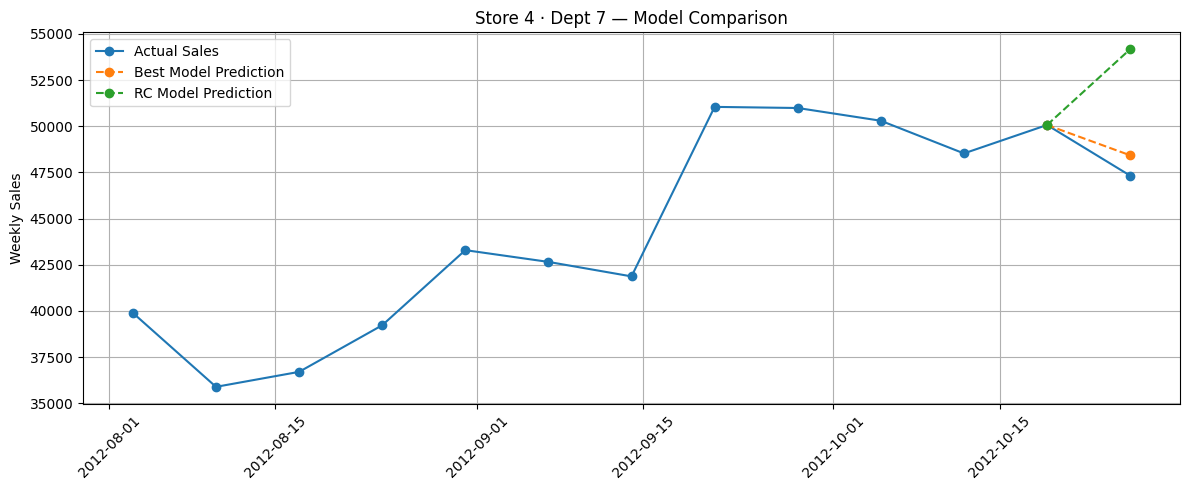

Baseline: 47,929.62
Best Model Prediction: 48,422.76
RC Model Prediction:   54,166.99
Actual Sales:          47,321.62


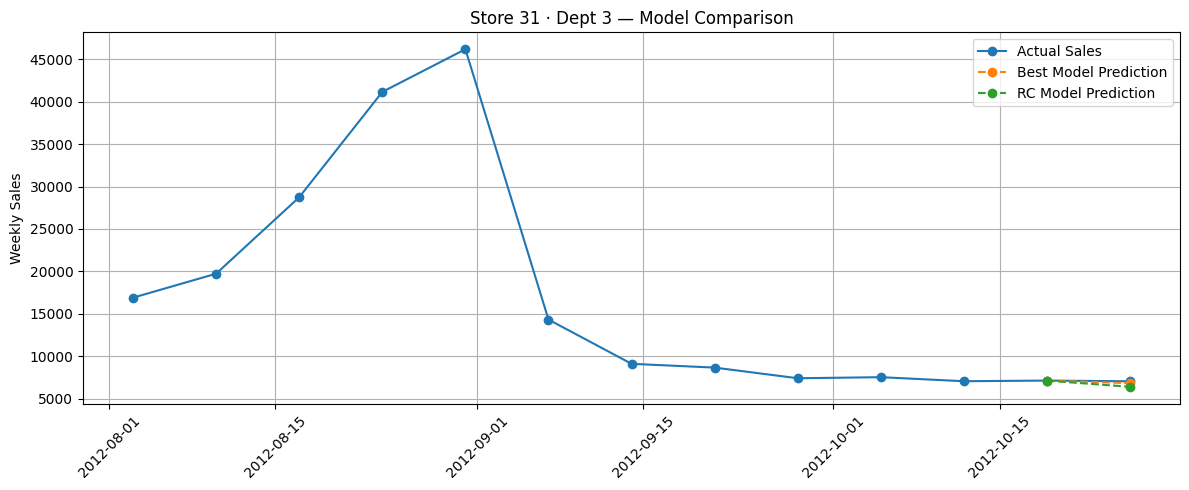

Baseline: 6,902.15
Best Model Prediction: 6,838.40
RC Model Prediction:   6,411.43
Actual Sales:          7,066.53


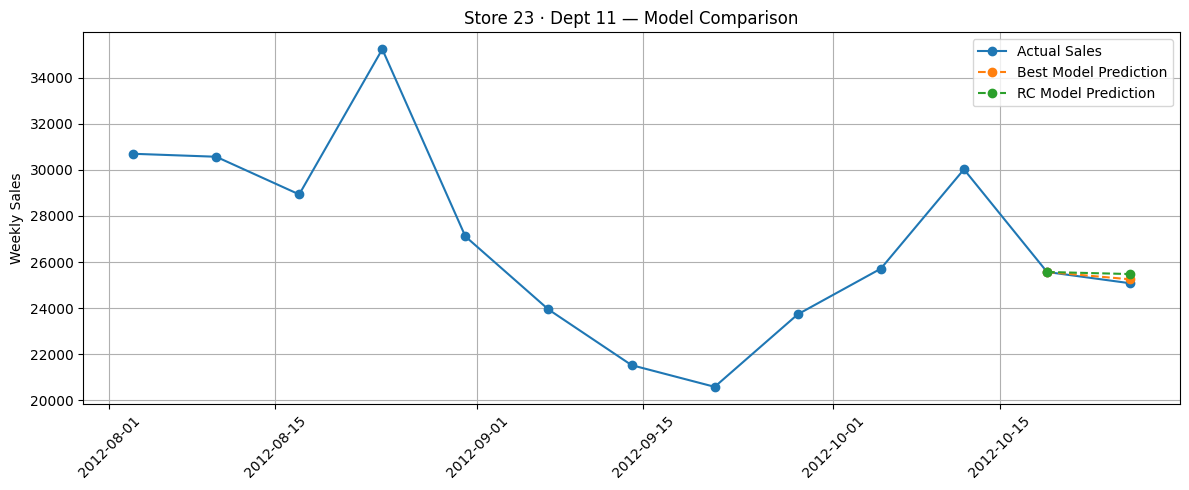

Baseline: 25,374.08
Best Model Prediction: 25,251.37
RC Model Prediction:   25,480.02
Actual Sales:          25,080.96


In [94]:
plot_model_comparison(4, 7)
plot_model_comparison(31, 3)
plot_model_comparison(23, 11)